In [308]:
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
import librosa
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from collections import Counter
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from audiomentations import Compose, AddGaussianNoise, Gain, Shift, ClippingDistortion, PitchShift
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from tensorflow.keras.regularizers import l2

## Loading data

In [111]:
root_folder = './RavDess'

In [215]:
def create_X_y():
    X_filepath = []
    y_class = []
    
    emotion_map = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }
    
    
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            y = filename.split("-")[2]
            emotion = emotion_map[y]
    
            if emotion:
                X_filepath.append(filepath)
                y_class.append(emotion)

    return X_filepath, y_class

In [207]:
X_filepath = []
y_class = []

emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}


for dirpath, dirnames, filenames in os.walk(root_folder):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        y = filename.split("-")[2]
        emotion = emotion_map[y]

        if emotion:
            X_filepath.append(filepath)
            y_class.append(emotion)

In [208]:
print(X_filepath[0], y_class[0])

./RavDess\Actor_01\03-01-01-01-01-01-01.wav neutral


In [114]:
len(y_class)

1440

In [115]:
len(X_filepath)

1440

In [209]:
labelEncoder = LabelEncoder()

y_mapped = labelEncoder.fit_transform(y_class)

In [210]:
class_counts = Counter(y_mapped)
print(class_counts)

Counter({np.int64(1): 192, np.int64(4): 192, np.int64(6): 192, np.int64(0): 192, np.int64(3): 192, np.int64(2): 192, np.int64(7): 192, np.int64(5): 96})


In [118]:
def augment_audio(y, sr=16000):
    augmented = []

    # Dodaj lekki szum
    noise = y + 0.002 * np.random.randn(len(y))
    augmented.append(noise)

    # Pitch shift +1 semiton
    pitch_up = librosa.effects.pitch_shift(y, sr=sr, n_steps=1)
    augmented.append(pitch_up)

    # Time stretch (zwolnienie)
    try:
        stretch = librosa.effects.time_stretch(y, rate=0.9)
        # Docięcie lub padding, żeby długość się zgadzała
        if len(stretch) > len(y):
            stretch = stretch[:len(y)]
        else:
            stretch = np.pad(stretch, (0, len(y) - len(stretch)))
        augmented.append(stretch)
    except:
        pass  # czasem librosa może rzucić błąd jeśli tempo niestabilne

    return augmented

In [120]:
def test_model(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print("accuracy of model: ", accuracy_score(y_test, y_pred))
    print("accuracy of model (train data): ", accuracy_score(y_train, y_pred_train))

### 1. MFCC + ML

In [121]:
def load_audio_fixed_length(path, sr=16000, duration=3.0):
    samples = int(sr * duration)
    y, _ = librosa.load(path, sr=sr, mono=True)
    if len(y) > samples:
        y = y[:samples]
    else:
        y = np.pad(y, (0, samples - len(y)))
    return y

In [122]:
def extract_mfcc_features(y, sr=16000, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    def summarize(feat):
        return np.concatenate([np.mean(feat, axis=1), np.std(feat, axis=1)])

    features = np.concatenate([
        summarize(mfcc),
        summarize(mfcc_delta),
    ])

    return features

In [78]:
X_mfcc = []

for path in X_filepath:
    y = load_audio_fixed_length(path)
    features = extract_mfcc_features(y)
    X_mfcc.append(features)

X_mfcc = np.array(X_mfcc)

In [127]:
print(X_filepath[0])
labelEncoder.inverse_transform(y_mapped)

./RavDess\Actor_01\03-01-01-01-01-01-01.wav


array(['neutral', 'neutral', 'neutral', ..., 'surprised', 'surprised',
       'surprised'], dtype='<U9')

In [128]:
X_train_filepath, X_test_filepath, y_train, y_test = train_test_split(X_filepath, y_mapped, random_state=42, train_size=0.8)

In [107]:
print(X_train_filepath[0], y_train[0])

./RavDess\Actor_20\03-01-02-02-01-01-20.wav 1


In [129]:
X_train_augmented = []
y_train_augmented = []

for path, label in zip(X_train_filepath, y_train):
    y = load_audio_fixed_length(path)
    base_feat = extract_mfcc_features(y)
    
    X_train_augmented.append(base_feat)
    y_train_augmented.append(label)

    for aug_y in augment_audio(y):
        aug_feat = extract_mfcc_features(aug_y)
        X_train_augmented.append(aug_feat)
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [130]:
X_test = []
for path in X_test_filepath:
    y = load_audio_fixed_length(path)
    features = extract_mfcc_features(y)
    X_test.append(features)
X_test = np.array(X_test)

### 1.1 SVM

In [132]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_augmented)
X_test_scaled = scaler.transform(X_test)

In [81]:
# X_test_scaled[0]

In [82]:
len(X_train)

1152

In [83]:
len(X_test)

288

In [143]:
svm = SVC(kernel="rbf", C=10, gamma='scale')
svm.fit(X_train_scaled, y_train_augmented)

SVC(C=10)

In [144]:
test_model(svm, X_train_scaled, X_test_scaled, y_train_augmented, y_test)

accuracy of model:  0.7222222222222222
accuracy of model (train data):  0.947265625


param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 'scale'],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, verbose=2)
grid.fit(X_train_scaled, y_train_augmented)

print("Best parameters:", grid.best_params_)
print("Test accuracy:", grid.best_estimator_.score(X_test_scaled, y_test))

### 1.2 RandomForest

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_mfcc, y_mapped, random_state=42, train_size=0.8)

In [161]:
rf = RandomForestClassifier(
    n_estimators=500,       
    max_depth=6,        
    random_state=42
)
rf.fit(X_train_augmented, y_train_augmented)

RandomForestClassifier(max_depth=6, n_estimators=500, random_state=42)

In [162]:
test_model(rf, X_train_augmented, X_test, y_train_augmented, y_test)

accuracy of model:  0.46875
accuracy of model (train data):  0.6631944444444444


### 1.3 XGBoost


In [190]:
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.2,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train_augmented, y_train_augmented)

C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:36:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [191]:
test_model(xgb, X_train_augmented, X_test, y_train_augmented, y_test)

accuracy of model:  0.6493055555555556
accuracy of model (train data):  1.0


In [187]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
                    param_grid, cv=3, verbose=2)
grid.fit(X_train_augmented, y_train_augmented)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   4.6s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   4.5s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   4.6s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   9.1s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   9.0s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   8.9s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   9.1s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:25:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   9.2s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:25:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   9.2s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:25:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=  17.8s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:25:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=  17.4s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:25:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=  18.2s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:26:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=100; total time=  16.6s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:26:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=100; total time=  16.6s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:26:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=100; total time=  16.4s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:27:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=200; total time=  29.2s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:27:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=200; total time=  29.8s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=200; total time=  25.4s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   3.8s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   3.9s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   4.2s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   8.9s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   8.7s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   8.7s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:29:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   8.6s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:29:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   8.5s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:29:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   9.0s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:29:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  16.5s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:29:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  16.4s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:30:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  16.4s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:30:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=  14.7s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:30:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=  14.7s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:30:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=  14.7s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:31:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=  24.7s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:31:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=  25.0s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:31:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=  24.8s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:32:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=   4.5s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:32:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=   4.4s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:32:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=   4.2s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:32:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=   8.7s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:32:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=   9.0s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:32:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=   8.9s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:33:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=   8.5s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:33:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=   8.2s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:33:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=   8.3s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:33:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time=  15.3s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:33:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time=  15.4s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:33:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time=  15.3s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:34:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=  12.4s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:34:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=  12.9s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:34:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=  12.7s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:34:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time=  19.7s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:35:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time=  19.7s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:35:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time=  19.9s


C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:35:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best score: 0.5828993055555557


In [186]:
test_model(xgb, X_train_augmented, X_test, y_train_augmented, y_test)

accuracy of model:  0.65625
accuracy of model (train data):  0.9995659722222222


### 2. Spektrogram + CNN

In [327]:
def get_mel_spectrogram(file_path, sr=16000, n_mels=128, duration=4, apply_aug=False, augmenter=None):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    
    if len(y) < sr * duration:
        y = np.pad(y, (0, sr * duration - len(y)))
    
    if apply_aug and augmenter:
        y = augmenter(samples=y, sample_rate=sr)

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    if mel_spec_db.shape[1] < 128:
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, 128 - mel_spec_db.shape[1])))
    elif mel_spec_db.shape[1] > 128:
        mel_spec_db = mel_spec_db[:, :128]
    
    return mel_spec_db

def show_spectrogram(filepath):
    spec = get_mel_spectrogram(filepath)
    plt.imshow(spec, aspect='auto', origin='lower')
    plt.title("Mel-Spectrogram")
    plt.colorbar()
    plt.show()


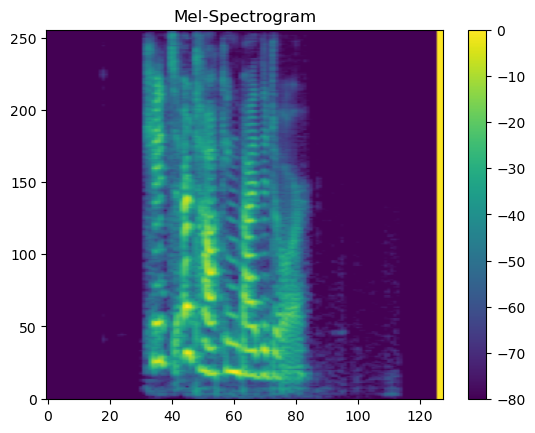

In [280]:
show_spectrogram("./RavDess\\Actor_02\\03-01-01-01-01-01-02.wav")

In [216]:
X_filepath, y = create_X_y()

In [217]:
X_filepath[0]

'./RavDess\\Actor_01\\03-01-01-01-01-01-01.wav'

In [236]:
y[0]

'neutral'

In [231]:
augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    Shift(min_shift=-0.1, max_shift=0.1, p=0.5),
    Gain(min_gain_db=-3, max_gain_db=3, p=0.5),
])

In [294]:
def get_augmented_data(augmenter, X_filepath, y, how_many):
    X = []
    Y = []
    
    for path, label in zip(X_filepath, y):
        X.append(get_mel_spectrogram(path))
        Y.append(label)
        
        for _ in range(how_many):
            X.append(get_mel_spectrogram(path, apply_aug=True, augmenter=augmenter))
            Y.append(label)

    return X, Y

In [237]:
X = []
Y = []

for path, label in zip(X_filepath, y):
    X.append(get_mel_spectrogram(path))
    Y.append(label)
    
    for _ in range(2):
        X.append(get_mel_spectrogram(path, apply_aug=True, augmenter=augmenter))
        Y.append(label)

In [256]:
le = LabelEncoder()
y_encoded = le.fit_transform(Y)

In [281]:
print(Counter(y_encoded))

Counter({np.int64(1): 576, np.int64(4): 576, np.int64(6): 576, np.int64(0): 576, np.int64(3): 576, np.int64(2): 576, np.int64(7): 576, np.int64(5): 288})


In [252]:
X = np.array(X)
X = X[..., np.newaxis]


In [258]:
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [261]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [262]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [263]:
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=30,
          batch_size=32)

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.1987 - loss: 8.4519 - val_accuracy: 0.2558 - val_loss: 2.0843
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.2608 - loss: 1.8351 - val_accuracy: 0.2859 - val_loss: 1.8944
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.2634 - loss: 1.8178 - val_accuracy: 0.2928 - val_loss: 1.8484
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.3163 - loss: 1.7361 - val_accuracy: 0.3148 - val_loss: 1.7322
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.3336 - loss: 1.6379 - val_accuracy: 0.4062 - val_loss: 1.5737
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.3876 - loss: 1.5640 - val_accuracy: 0.4479 - val_loss: 1.4751
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3987 - loss: 1.4857 - val_accuracy: 0.4826 - val_loss: 1.4374
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.4008 - loss: 1.4355 - val_accu

In [264]:
loss, acc = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {acc:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.6671 - loss: 1.0773
Validation accuracy: 0.6539


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step


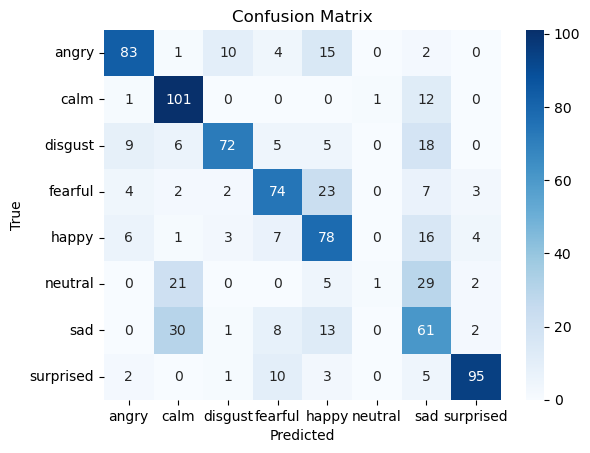

              precision    recall  f1-score   support

       angry       0.79      0.72      0.75       115
        calm       0.62      0.88      0.73       115
     disgust       0.81      0.63      0.71       115
     fearful       0.69      0.64      0.66       115
       happy       0.55      0.68      0.61       115
     neutral       0.50      0.02      0.03        58
         sad       0.41      0.53      0.46       115
   surprised       0.90      0.82      0.86       116

    accuracy                           0.65       864
   macro avg       0.66      0.61      0.60       864
weighted avg       0.67      0.65      0.64       864



In [269]:
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_val, y_pred, target_names=le.classes_))

In [324]:
model_v2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(le.classes_), activation='softmax')
])

In [323]:
model_v2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50



KeyboardInterrupt



In [275]:
loss, acc = model_v2.evaluate(X_val, y_val)
print(f"Validation accuracy: {acc:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.7675 - loss: 0.6835 
Validation accuracy: 0.7581


In [329]:
X_2, Y_2 = get_augmented_data(augmenter_new, X_filepath, Y, 4)

In [330]:

X_2 =  np.array(X_2)
X_2 = X_2[..., np.newaxis]

In [331]:
len(X_2)

7200

In [332]:
X_2 = (X_2 - X_2.mean()) / X_2.std()

In [333]:
le_new = LabelEncoder()
y_encoded = le_new.fit_transform(Y_2)

In [334]:
X_train, X_val, y_train, y_val = train_test_split(X_2, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [335]:
len(X_train)

5760

In [336]:
X_train[0]

array([[[0.6935225 ],
        [1.0826677 ],
        [1.1225653 ],
        ...,
        [0.893132  ],
        [2.1921542 ],
        [2.1921542 ]],

       [[0.80129486],
        [0.9416768 ],
        [1.1069632 ],
        ...,
        [0.9540922 ],
        [2.1921542 ],
        [2.1921542 ]],

       [[0.80449194],
        [0.89819133],
        [0.90342295],
        ...,
        [0.75705945],
        [2.1921542 ],
        [2.1921542 ]],

       ...,

       [[0.8488355 ],
        [0.9560585 ],
        [0.84814966],
        ...,
        [0.7691555 ],
        [2.1921542 ],
        [2.1921542 ]],

       [[0.81898147],
        [0.94290566],
        [0.9764678 ],
        ...,
        [0.8623133 ],
        [2.1921542 ],
        [2.1921542 ]],

       [[0.82877886],
        [0.9454789 ],
        [0.9453414 ],
        ...,
        [0.8691468 ],
        [2.1921542 ],
        [2.1921542 ]]], dtype=float32)

In [328]:
augmenter_new = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    Shift(min_shift=-0.1, max_shift=0.1, p=0.5),
    Gain(min_gain_db=-3, max_gain_db=3, p=0.5),
    ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=10, p=0.3),
    PitchShift(min_semitones=-1, max_semitones=1, p=0.5),
])

In [337]:
model_v3 = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\kacpe\anaconda3\envs\interview_better\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
 25/180 ━━━━━━━━━━━━━━━━━━━━ 2:58 1s/step - accuracy: 0.1717 - loss: 55.5041 